In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf __MACOSX

In [ ]:
!unzip -qq /content/drive/MyDrive/Colab\ Notebooks/Milk/milk_3.zip

In [ ]:
import json
import os
import shutil
import cv2
from tqdm import tqdm

dataset_root = 'milk_3'
raw_images_dir = f'{dataset_root}/images'
classification_root = 'data_classification'

shutil.rmtree(classification_root, ignore_errors=True)

with open(f'{dataset_root}/result.json') as json_fp:
    json_contents = json.load(json_fp)

class_correspondence = {}
for categorie in json_contents['categories']:
    class_correspondence[categorie['id']] = categorie['name']
    os.makedirs(f"{classification_root}/{categorie['id']}", exist_ok=True)

for image_contents in tqdm(json_contents['images']):
    file_name = image_contents['file_name'].replace('images/2', 'images')
    image_path = str(os.path.join(dataset_root, file_name))
    image = cv2.imread(image_path)

    for annotation in json_contents['annotations']:
        if annotation['image_id'] == image_contents['id']:
            x, y = annotation['bbox'][0], annotation['bbox'][1]
            w, h = annotation['bbox'][2], annotation['bbox'][3]

            image_crop = image[y:y+h, x:x+w]
            cv2.imwrite(f"{classification_root}/"\
                f"{annotation['category_id']}/"\
                f"{annotation['id']}.jpg", image_crop)

100%|██████████| 198/198 [01:01<00:00,  3.22it/s]


MobileNet

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
batch_size = 16
image_height = 224
image_width = 224

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    classification_root,
    validation_split=0.2,
    subset="training",
    seed=100,
    image_size=(image_height, image_width),
    batch_size=batch_size)

Found 2291 files belonging to 131 classes.
Using 1833 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    classification_root,
    validation_split=0.2,
    subset="validation",
    seed=100,
    shuffle=False,
    image_size=(image_height, image_width),
    batch_size=batch_size)

Found 2291 files belonging to 131 classes.
Using 458 files for validation.


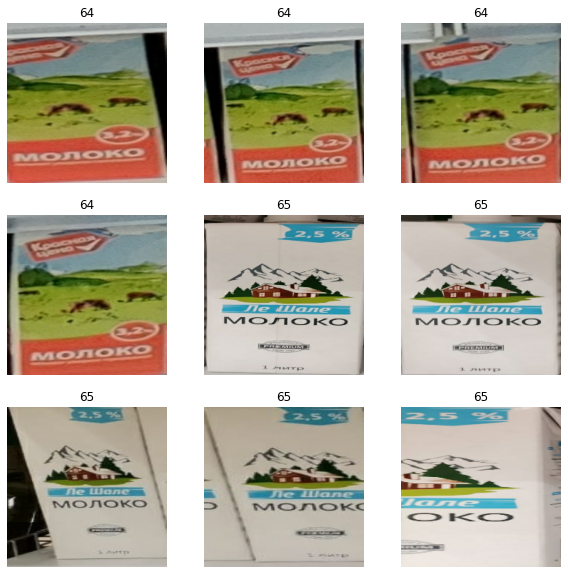

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal', seed=42),
    tf.keras.layers.RandomRotation(0.15, seed=42),
    tf.keras.layers.RandomContrast(0.5, seed=42)
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

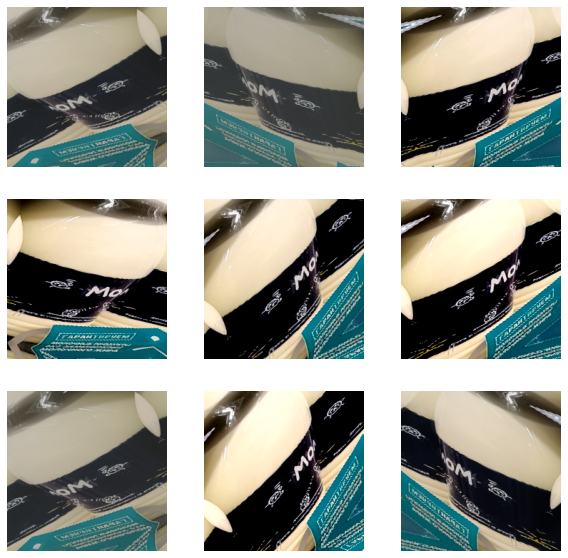

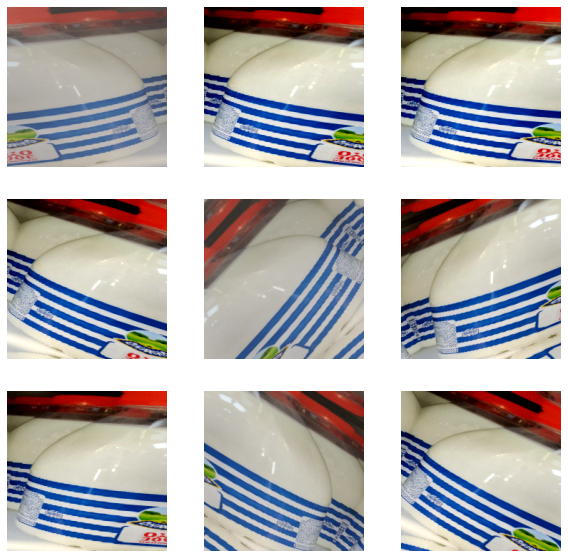

In [ ]:
for image, _ in train_dataset.take(2):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(image_height, image_width, 3,),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(image_height, image_width, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(train_ds.class_names))(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 5
model.evaluate(validation_dataset)

24/24 [==============================] - 4s 71ms/step - loss: 12.4376 - accuracy: 0.0000e+00


[12.43760871887207, 0.0]

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
115/115 [==============================] - 12s 76ms/step - loss: 10.0532 - accuracy: 0.2259 - val_loss: 14.9226 - val_accuracy: 0.0000e+00
Epoch 2/5
115/115 [==============================] - 9s 74ms/step - loss: 11.0656 - accuracy: 0.2651 - val_loss: 13.8565 - val_accuracy: 0.0026
Epoch 3/5
115/115 [==============================] - 9s 75ms/step - loss: 10.7153 - accuracy: 0.2646 - val_loss: 14.5205 - val_accuracy: 0.0000e+00
Epoch 4/5
115/115 [==============================] - 9s 75ms/step - loss: 9.9012 - accuracy: 0.2564 - val_loss: 14.3529 - val_accuracy: 0.0053
Epoch 5/5
115/115 [==============================] - 9s 76ms/step - loss: 9.8824 - accuracy: 0.2799 - val_loss: 13.9204 - val_accuracy: 0.0608


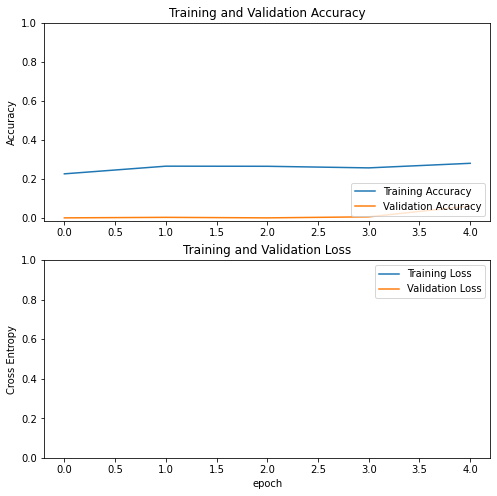

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
#As you are training a much larger model and want to readapt the pretrained weights, 
#it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/20),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/45
115/115 [==============================] - 15s 86ms/step - loss: 3.3317 - accuracy: 0.3208 - val_loss: 3.0281 - val_accuracy: 0.3519
Epoch 6/45
115/115 [==============================] - 10s 80ms/step - loss: 2.6474 - accuracy: 0.4075 - val_loss: 2.8032 - val_accuracy: 0.3730
Epoch 7/45
115/115 [==============================] - 10s 80ms/step - loss: 2.1324 - accuracy: 0.4910 - val_loss: 1.9571 - val_accuracy: 0.5159
Epoch 8/45
115/115 [==============================] - 10s 80ms/step - loss: 1.7386 - accuracy: 0.5679 - val_loss: 1.7649 - val_accuracy: 0.5238
Epoch 9/45
115/115 [==============================] - 10s 80ms/step - loss: 1.4505 - accuracy: 0.6268 - val_loss: 1.7449 - val_accuracy: 0.5238
Epoch 10/45
115/115 [==============================] - 10s 80ms/step - loss: 1.2403 - accuracy: 0.6874 - val_loss: 1.1695 - val_accuracy: 0.6772
Epoch 11/45
115/115 [==============================] - 10s 80ms/step - loss: 1.0488 - accuracy: 0.7179 - val_loss: 1.2296 - val_accurac

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

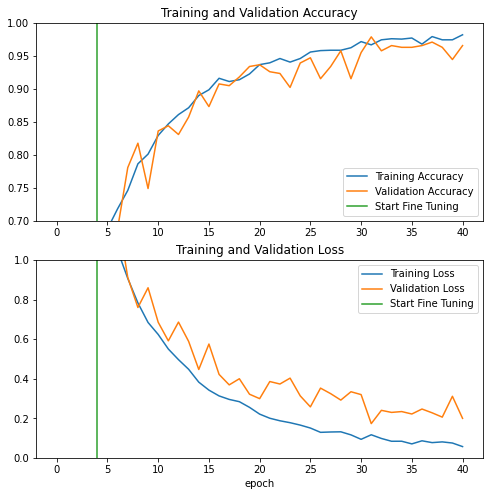

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 0s 58ms/step - loss: 0.3719 - accuracy: 0.9125
Test accuracy : 0.9125000238418579


In [ ]:
softmax_outputs = tf.nn.softmax(model.outputs[0])

softmax_model = tf.keras.Model(
    inputs=[model.layers[2].input],
    outputs=softmax_outputs
)

In [ ]:
for file_name in os.listdir('.'):
    if file_name.endswith('.jpeg'):
        image_path = file_name

        img = tf.keras.utils.load_img(image_path, target_size=(image_height, image_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = softmax_model.predict(img_array)

        arg_max, arg_second_max = np.array(predictions[0]).argsort()[-2:][::-1]
        class_name = train_ds.class_names[arg_max]

        if class_correspondence[int(class_name)] in ['Не та категория товара', 'Плохой bbox']:
            class_name = train_ds.class_names[arg_second_max]

        print(f"{file_name} This image most likely belongs to \
            {class_correspondence[int(class_name)]}")

orig.jpeg This image most likely belongs to             Молоко Домик в деревне 3,2% ультрапастеризованное
1022720526.jpeg This image most likely belongs to             Молоко Вкуснотеево 3,2% ультрапастеризованное


In [ ]:
softmax_model.save('model_mobilenet.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(
    tf.keras.models.load_model('model_mobilenet.h5'))
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpq0khmcgx/assets


9539768

In [ ]:
for class_name in train_ds.class_names:
    print(class_correspondence[int(class_name)])

Большая кружка Молоко ультрапастеризованное, 3,2%
Молоко Billa 2,5%, пастеризованное
Молоко Авида топленое
Молоко Село Зеленое 2,5% ультрапастеризованное
Молоко Село Зеленое 3,2% пастеризованное
Молоко Село Зеленое 3,2% ультрапастеризованное
Молоко Тяжин ультрапастеризованное  3,2%
Молоко Фрау Му пастеризованное 3,2%
Молоко Фрау Му ультрапастеризованное 2,5%
Молоко Фрау Му ультрапастеризованное 3,2%
Молоко Хорошее Дело ультрапастеризованное 2,5%
Молоко Хорошее Дело ультрапастеризованное 3,2%
Молоко Хуторок 2,5% пастеризованное
Молоко Амка пастеризованное 3,2%
Молоко Хуторок 3,2% пастеризованное
Молоко ЭГО пастеризованное
Молоко ЭкоНива ультрапастеризованное 2.5%
Молоко ЭкоНива ультрапастеризованное 3.2%
Молоко Экомилк 3,2% пастеризованное
Молоко Экомилк отборное пастеризованное
Молоко Ясный луг ультрапастеризованное питьевое 3.2%
Молоко нашей дойки 3,5% пастеризованное
Молоко от фермера пастеризованное 3,2%
Молоко пастеризованное ЭКОВАКИНО 3,4–6%
Молоко Амка ультрапастеризованное 3,2%
